## RNN for Human Activity Recognition - 2D Pose Input

This experiment is the classification of human activities using a 2D pose time series dataset and an LSTM RNN.
The idea is to prove the concept that using a series of 2D poses, rather than 3D poses or a raw 2D images, can produce an accurate estimation of the behaviour of a person or animal.
This is a step towards creating a method of classifying an animal's current behaviour state and predicting it's likely next state, allowing for better interaction with an autonomous mobile robot.

## Objectives

The aims of this experiment are:

-  To determine if 2D pose has comparable accuracy to 3D pose for use in activity recognition. This would allow the use of RGB only cameras for human and animal pose estimation, as opposed to RGBD or a large motion capture dataset.


- To determine if  2D pose has comparable accuracy to using raw RGB images for use in activity recognition. This is based on the idea that limiting the input feature vector can help to deal with a limited dataset, as is likely to occur in animal activity recognition, by allowing for a smaller model to be used (citation required).


- To verify the concept for use in future works involving behaviour prediction from motion in 2D images.

The network used in this experiment is based on that of Guillaume Chevalier, 'LSTMs for Human Activity Recognition, 2016'  https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition, available under the MIT License.
Notable changes that have been made (other than accounting for dataset sizes) are:
 - Adapting for use with a large dataset ordered by class, using random sampling without replacement for mini-batch.  
 This allows for use of smaller batch sizes when using a dataset ordered by class. "It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize"  
      _N.S Keskar, D. Mudigere, et al, 'On Large-Batch Training for Deep Learning: Generalization Gap and Sharp 
      Minima', ICLR 2017_ https://arxiv.org/abs/1609.04836
      
 - Exponentially decaying learning rate implemented



## Dataset overview

The dataset consists of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is comprised of 12 subjects doing the following 6 actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  

- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](images/boxing_all_views.gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input (where j refers to a joint) is stored as:

[  j0_x,  j0_y, j1_x, j1_y , j2_x, j2_y, j3_x, j3_y, j4_x, j4_y, j5_x, j5_y, j6_x, j6_y, j7_x, j7_y, j8_x, j8_y, j9_x, j9_y, j10_x, j10_y, j11_x, j11_y, j12_x, j12_y, j13_x, j13_y, j14_x, j14_y, j15_x, j15_y, j16_x, j16_y, j17_x, j17_y ]

For the following experiment, very little preprocessing has been done to the dataset.  
The following steps were taken:
1. openpose run on individual frames, for each subject, action and view, outputting JSON of 18 joint x and y position keypoints and accuracies per frame
2. JSONs converted into txt format, keeping only x and y positions of each frame, action being performed during frame, and order of frames. This is used to create a database of associated activity class number and corresponding series of joint 2D positions
3. No further prepossessing was performed.  

In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 32 frames (~=1.5s at 22Hz)
 - Images with noisy pose detection (detection of >=2 people) = 5132  
 - Training_split = 0.8
 - Overlap = 0.8125 (26 / 32) ie 26 frame overlap
   - Length X_train = 22625 * 32 frames
   - Length X_test = 5751 * 32 frames
   
Note that their is no overlap between test and train sets, which were seperated by activity repetition entirely, before creating the 26 of 32 frame overlap.




## Training and Results below: 
Training took approximately 4 mins running on a single GTX1080Ti, and was run for 22,000,000ish iterations with a batch size of 5000  (600 epochs)


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import random
from random import randint
import time
import os

## Preparing dataset:

In [2]:
# Useful Constants

# Output classes to learn how to classify
# LABELS = [    
#     "JUMPING",
#     "JUMPING_JACKS",
# #     "BOXING",
#     "WAVING_2HANDS",
#     "WAVING_1HAND",
#     "CLAPPING_HANDS"
# ] 

# LABELS = [    
#     "GO_IN",
#     "GO_OUT",
#     "WALK_LEFT",
#     "WALK_RIGHT"
# ] 

# LABELS = [    
#     "normal", "anomaly"
# ] 

LABELS = [
    "jalan_UL", "jalan_DR", "jalan_UR", "jalan_DL",
    "sapu_UL", "sapu_DR", "sapu_UR", "sapu_DL",
    # "barang_UL", "barang_DR", "barang_UR", "barang_DL",
    # "out_door_SE", "out_door_SW", "in_door_SE", "in_door_SW",
    "idle"
]

# LABELS = [    
#     "jalan_NE", "jalan_NW", "jalan_SE", "jalan_SW",
#     "menyapu_NE", "menyapu_NW", "menyapu_SE", "menyapu_SW",
#     "barang_NE", "barang_NW", "barang_SE", "barang_SW",
#     "diam_NE", "diam_NW", "diam_SE", "diam_SW"
# ] 

# DATASET_PATH = "data/HAR_pose_activities/database/"
# DATASET_PATH = "data/HAR_pose_activities/database/Training Default/"

# DATASET_PATH = "data/Overlap_fixed4_separated/"

DATASET_PATH = "data/Direct/NoDoor/NoSweep/NormalizeOnce/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"
# X_test_path = "utilities/something/something.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

# n_steps = 32 # 32 timesteps per series
# n_steps = 1

# n_steps = 5
n_steps = 8

In [3]:

# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Set Parameters:


In [4]:
# Input Data 

training_data_count = len(X_train)  # 4519 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 1197 test series
n_input = len(X_train[0][0])  # num input parameters per timestep

n_hidden = 36 # Hidden layer num of features
# n_classes = 6 
n_classes = len(LABELS)

#updated for learning-rate decay
# calculated as: decayed_learning_rate = init_learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.0025 #used if decaying_learning_rate set to False

init_learning_rate = 0.005
# init_learning_rate = 0.00015

decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

# training_iters = training_data_count *300  # Loop 300 times on the dataset, ie 300 epochs
# training_iters = training_data_count *60
# training_iters = training_data_count *120
# training_iters = training_data_count *1
# batch_size = 5
batch_size = 64
# batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
(1251, 8, 36) (1251, 1) 2.6286652 58.470573

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        
        _unsampled = list(_unsampled)
        
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:
# for _ in range(3):
#     tf.reset_default_graph()
#     var = tf.Variable(0)
#     with tf.Session() as session:
#         session.run(tf.global_variables_initializer())
#         print(len(session.graph._nodes_by_name.keys()))

In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

# correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



Instructions for updating:
This class is deprecated, please use tf.nn.rnn_cell.LSTMCell, which supports all the feature this cell currently has. Please replace the existing code with tf.nn.rnn_cell.LSTMCell(name='basic_lstm_cell').
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [8]:
print(biases)
print(weights['hidden'])

{'out': <tf.Variable 'Variable_4:0' shape=(9,) dtype=float32_ref>, 'hidden': <tf.Variable 'Variable_3:0' shape=(36,) dtype=float32_ref>}
<tf.Variable 'Variable_1:0' shape=(36, 36) dtype=float32_ref>


In [9]:
# if decaying_learning_rate:
#     learning_rate = tf.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)

## Train the network:

In [10]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()

sess.run(init)

In [11]:
# training_iters = training_data_count *120
# training_iters = training_data_count *5120
# training_iters = training_data_count *2560
# training_iters = training_data_count *1024
training_iters = training_data_count *512
# training_iters = training_data_count *1024
# training_iters = training_data_count *5120

#create saver before training
# saver = tf.train.Saver()
saver = tf.train.Saver(var_list={'wh':weights['hidden'], 'wo':weights['out'], 'bh':biases['hidden'], 'bo':biases['out']})
load = False
train = True
update = True

#check if you want to retrain or import a saved model
if load:
    saver.restore(sess, DATASET_PATH + "model.ckpt")
    print("Model restored.")

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [12]:
# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = range(0,len(X_train))

if not train:
    
    # only perform testing - on training set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_train,
            y: one_hot(y_train)
        }
    )
    
    print("PERFORMANCE ON TRAIN SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))
    
    # only perform testing - on test set
    loss, acc = sess.run(
        [cost, accuracy], 
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )
    
    print("PERFORMANCE ON TEST SET:             " + \
          "Batch Loss = {}".format(loss) + \
          ", Accuracy = {}".format(acc))

while train and (step * batch_size <= training_iters):
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = range(0,len(X_train)) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy_fin, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy_fin)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy_fin))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))

Iter #64:  Learning rate = 0.005000:   Batch Loss = 4.646913, Accuracy = 0.140625
PERFORMANCE ON TEST SET:             Batch Loss = 4.085938453674316, Accuracy = 0.1686650663614273
Iter #512:  Learning rate = 0.005000:   Batch Loss = 3.382502, Accuracy = 0.40625
PERFORMANCE ON TEST SET:             Batch Loss = 3.201423406600952, Accuracy = 0.48840928077697754
Iter #1024:  Learning rate = 0.005000:   Batch Loss = 2.731783, Accuracy = 0.65625
PERFORMANCE ON TEST SET:             Batch Loss = 2.8768060207366943, Accuracy = 0.5339727997779846
Iter #1536:  Learning rate = 0.005000:   Batch Loss = 2.779438, Accuracy = 0.5625
PERFORMANCE ON TEST SET:             Batch Loss = 2.703558921813965, Accuracy = 0.5883293151855469
Iter #2048:  Learning rate = 0.005000:   Batch Loss = 2.702801, Accuracy = 0.609375
PERFORMANCE ON TEST SET:             Batch Loss = 2.620879650115967, Accuracy = 0.6131095290184021
Iter #2560:  Learning rate = 0.005000:   Batch Loss = 2.427491, Accuracy = 0.671875
PERFOR

Iter #23552:  Learning rate = 0.005000:   Batch Loss = 1.712924, Accuracy = 0.78125
PERFORMANCE ON TEST SET:             Batch Loss = 1.8553272485733032, Accuracy = 0.7282174229621887
Iter #24064:  Learning rate = 0.005000:   Batch Loss = 1.845046, Accuracy = 0.6875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7992923259735107, Accuracy = 0.7442046403884888
Iter #24576:  Learning rate = 0.005000:   Batch Loss = 1.754356, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.7767040729522705, Accuracy = 0.7625899314880371
Iter #25088:  Learning rate = 0.005000:   Batch Loss = 1.761015, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.7711808681488037, Accuracy = 0.7458033561706543
Iter #25600:  Learning rate = 0.005000:   Batch Loss = 1.643693, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.7570449113845825, Accuracy = 0.7362110018730164
Iter #26112:  Learning rate = 0.005000:   Batch Loss = 1.686643, Accuracy = 0.

Iter #47104:  Learning rate = 0.005000:   Batch Loss = 1.511580, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.4422242641448975, Accuracy = 0.8057553768157959
Iter #47616:  Learning rate = 0.005000:   Batch Loss = 1.439157, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4257360696792603, Accuracy = 0.8153477311134338
Iter #48128:  Learning rate = 0.005000:   Batch Loss = 1.321461, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.4019973278045654, Accuracy = 0.8073540925979614
Iter #48640:  Learning rate = 0.005000:   Batch Loss = 1.283911, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.4302115440368652, Accuracy = 0.7865707278251648
Iter #49152:  Learning rate = 0.005000:   Batch Loss = 1.553861, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.406822919845581, Accuracy = 0.7977617979049683
Iter #49664:  Learning rate = 0.005000:   Batch Loss = 1.411950, Accuracy = 0.7

Iter #70144:  Learning rate = 0.005000:   Batch Loss = 1.408246, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.3625633716583252, Accuracy = 0.7809752225875854
Iter #70656:  Learning rate = 0.005000:   Batch Loss = 1.254618, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.288954257965088, Accuracy = 0.8097522258758545
Iter #71168:  Learning rate = 0.005000:   Batch Loss = 1.444854, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2940559387207031, Accuracy = 0.8057553768157959
Iter #71680:  Learning rate = 0.005000:   Batch Loss = 1.300370, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 1.254040002822876, Accuracy = 0.8209432363510132
Iter #72192:  Learning rate = 0.005000:   Batch Loss = 1.395585, Accuracy = 0.765625
PERFORMANCE ON TEST SET:             Batch Loss = 1.2470648288726807, Accuracy = 0.8193445205688477
Iter #72704:  Learning rate = 0.005000:   Batch Loss = 1.333984, Accuracy = 0.

Iter #93184:  Learning rate = 0.005000:   Batch Loss = 1.082743, Accuracy = 0.828125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1459095478057861, Accuracy = 0.8329336643218994
Iter #93696:  Learning rate = 0.005000:   Batch Loss = 1.375231, Accuracy = 0.734375
PERFORMANCE ON TEST SET:             Batch Loss = 1.2134382724761963, Accuracy = 0.8001598715782166
Iter #94208:  Learning rate = 0.005000:   Batch Loss = 1.009110, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1376540660858154, Accuracy = 0.8417266011238098
Iter #94720:  Learning rate = 0.005000:   Batch Loss = 0.996976, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 1.1530930995941162, Accuracy = 0.824940025806427
Iter #95232:  Learning rate = 0.005000:   Batch Loss = 1.162953, Accuracy = 0.8125
PERFORMANCE ON TEST SET:             Batch Loss = 1.1483197212219238, Accuracy = 0.8345323801040649
Iter #95744:  Learning rate = 0.005000:   Batch Loss = 1.054578, Accuracy = 0.8

Iter #117248:  Learning rate = 0.004800:   Batch Loss = 1.085680, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.9759389162063599, Accuracy = 0.8776978254318237
Iter #117760:  Learning rate = 0.004800:   Batch Loss = 1.060957, Accuracy = 0.796875
PERFORMANCE ON TEST SET:             Batch Loss = 0.9990266561508179, Accuracy = 0.8705036044120789
Iter #118272:  Learning rate = 0.004800:   Batch Loss = 0.799605, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.9718295335769653, Accuracy = 0.8752997517585754
Iter #118784:  Learning rate = 0.004800:   Batch Loss = 0.969504, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 1.0093283653259277, Accuracy = 0.8577138185501099
Iter #119296:  Learning rate = 0.004800:   Batch Loss = 0.936952, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.983951210975647, Accuracy = 0.8705036044120789
Iter #119808:  Learning rate = 0.004800:   Batch Loss = 1.092304, Accuracy 

Iter #140288:  Learning rate = 0.004800:   Batch Loss = 0.938281, Accuracy = 0.859375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8887548446655273, Accuracy = 0.8968824744224548
Iter #140800:  Learning rate = 0.004800:   Batch Loss = 0.906529, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8894166946411133, Accuracy = 0.8968824744224548
Iter #141312:  Learning rate = 0.004800:   Batch Loss = 0.925907, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8865641355514526, Accuracy = 0.8872901797294617
Iter #141824:  Learning rate = 0.004800:   Batch Loss = 0.861111, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8693497776985168, Accuracy = 0.8976818323135376
Iter #142336:  Learning rate = 0.004800:   Batch Loss = 0.905821, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.8603142499923706, Accuracy = 0.9096722602844238
Iter #142848:  Learning rate = 0.004800:   Batch Loss = 0.860794, Accuracy = 0.

Iter #163840:  Learning rate = 0.004800:   Batch Loss = 0.712437, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8051776885986328, Accuracy = 0.9080735445022583
Iter #164352:  Learning rate = 0.004800:   Batch Loss = 0.890891, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.81416916847229, Accuracy = 0.8968824744224548
Iter #164864:  Learning rate = 0.004800:   Batch Loss = 0.649277, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.833147406578064, Accuracy = 0.9000799655914307
Iter #165376:  Learning rate = 0.004800:   Batch Loss = 0.850409, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.8451786041259766, Accuracy = 0.8880895376205444
Iter #165888:  Learning rate = 0.004800:   Batch Loss = 0.952464, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.865354061126709, Accuracy = 0.8904876112937927
Iter #166400:  Learning rate = 0.004800:   Batch Loss = 0.768953, Accuracy = 0.921

Iter #187904:  Learning rate = 0.004800:   Batch Loss = 0.753425, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7941365242004395, Accuracy = 0.9032773971557617
Iter #188416:  Learning rate = 0.004800:   Batch Loss = 0.806795, Accuracy = 0.90625
PERFORMANCE ON TEST SET:             Batch Loss = 0.7692098617553711, Accuracy = 0.9112709760665894
Iter #188928:  Learning rate = 0.004800:   Batch Loss = 0.870673, Accuracy = 0.84375
PERFORMANCE ON TEST SET:             Batch Loss = 0.8008028268814087, Accuracy = 0.8920863270759583
Iter #189440:  Learning rate = 0.004800:   Batch Loss = 0.795232, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.75737464427948, Accuracy = 0.9224620461463928
Iter #189952:  Learning rate = 0.004800:   Batch Loss = 0.676271, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.7561416625976562, Accuracy = 0.9168664813041687
Iter #190464:  Learning rate = 0.004800:   Batch Loss = 0.764533, Accuracy = 

Iter #210944:  Learning rate = 0.004608:   Batch Loss = 0.671537, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.7170815467834473, Accuracy = 0.9216626882553101
Iter #211456:  Learning rate = 0.004608:   Batch Loss = 0.691712, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6950045824050903, Accuracy = 0.9368505477905273
Iter #211968:  Learning rate = 0.004608:   Batch Loss = 0.758132, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.6964016556739807, Accuracy = 0.9312549829483032
Iter #212480:  Learning rate = 0.004608:   Batch Loss = 0.672280, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6991427540779114, Accuracy = 0.9248601198196411
Iter #212992:  Learning rate = 0.004608:   Batch Loss = 0.657209, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.7283319234848022, Accuracy = 0.9088729023933411
Iter #213504:  Learning rate = 0.004608:   Batch Loss = 0.749703, Accura

PERFORMANCE ON TEST SET:             Batch Loss = 0.6437383890151978, Accuracy = 0.9432454109191895
Iter #235008:  Learning rate = 0.004608:   Batch Loss = 0.537221, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.6740573048591614, Accuracy = 0.9328536987304688
Iter #235520:  Learning rate = 0.004608:   Batch Loss = 0.785408, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6531743407249451, Accuracy = 0.9360511302947998
Iter #236032:  Learning rate = 0.004608:   Batch Loss = 0.741303, Accuracy = 0.875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6511588096618652, Accuracy = 0.9400479793548584
Iter #236544:  Learning rate = 0.004608:   Batch Loss = 0.618577, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6569195985794067, Accuracy = 0.9360511302947998
Iter #237056:  Learning rate = 0.004608:   Batch Loss = 0.602864, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6167978644371033, Accuracy = 0.9

Iter #257536:  Learning rate = 0.004608:   Batch Loss = 0.531249, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6088120937347412, Accuracy = 0.9440447688102722
Iter #258048:  Learning rate = 0.004608:   Batch Loss = 0.503579, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5704815983772278, Accuracy = 0.9584332704544067
Iter #258560:  Learning rate = 0.004608:   Batch Loss = 0.616432, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6005759239196777, Accuracy = 0.948041558265686
Iter #259072:  Learning rate = 0.004608:   Batch Loss = 0.792845, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6495832204818726, Accuracy = 0.9328536987304688
Iter #259584:  Learning rate = 0.004608:   Batch Loss = 0.629131, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6134598255157471, Accuracy = 0.9416466951370239
Iter #260096:  Learning rate = 0.004608:   Batch Loss = 0.675848, Accuracy = 0.

Iter #280576:  Learning rate = 0.004608:   Batch Loss = 0.536720, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5862178206443787, Accuracy = 0.9512389898300171
Iter #281088:  Learning rate = 0.004608:   Batch Loss = 0.655913, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5719199180603027, Accuracy = 0.9584332704544067
Iter #281600:  Learning rate = 0.004608:   Batch Loss = 0.563119, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5737142562866211, Accuracy = 0.9528377056121826
Iter #282112:  Learning rate = 0.004608:   Batch Loss = 0.538054, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.5909440517425537, Accuracy = 0.9440447688102722
Iter #282624:  Learning rate = 0.004608:   Batch Loss = 0.586332, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6795858144760132, Accuracy = 0.9232614040374756
Iter #283136:  Learning rate = 0.004608:   Batch Loss = 0.621339, Accuracy =

Iter #304640:  Learning rate = 0.004424:   Batch Loss = 0.805470, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5865796208381653, Accuracy = 0.944844126701355
Iter #305152:  Learning rate = 0.004424:   Batch Loss = 0.612805, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.6402370929718018, Accuracy = 0.9216626882553101
Iter #305664:  Learning rate = 0.004424:   Batch Loss = 0.760054, Accuracy = 0.890625
PERFORMANCE ON TEST SET:             Batch Loss = 0.626789927482605, Accuracy = 0.9216626882553101
Iter #306176:  Learning rate = 0.004424:   Batch Loss = 0.614201, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5982789993286133, Accuracy = 0.935251772403717
Iter #306688:  Learning rate = 0.004424:   Batch Loss = 0.569400, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5633653998374939, Accuracy = 0.9488409161567688
Iter #307200:  Learning rate = 0.004424:   Batch Loss = 0.668001, Accurac

Iter #327680:  Learning rate = 0.004424:   Batch Loss = 0.470700, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.558535635471344, Accuracy = 0.9472422003746033
Iter #328192:  Learning rate = 0.004424:   Batch Loss = 0.477069, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.59967440366745, Accuracy = 0.932054340839386
Iter #328704:  Learning rate = 0.004424:   Batch Loss = 0.573819, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.6359864473342896, Accuracy = 0.9144684076309204
Iter #329216:  Learning rate = 0.004424:   Batch Loss = 0.548171, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5932813882827759, Accuracy = 0.9368505477905273
Iter #329728:  Learning rate = 0.004424:   Batch Loss = 0.602487, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.6297512054443359, Accuracy = 0.9248601198196411
Iter #330240:  Learning rate = 0.004424:   Batch Loss = 0.677596, Accuracy = 

Iter #351232:  Learning rate = 0.004424:   Batch Loss = 0.481957, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5422755479812622, Accuracy = 0.9472422003746033
Iter #351744:  Learning rate = 0.004424:   Batch Loss = 0.537297, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5390324592590332, Accuracy = 0.9528377056121826
Iter #352256:  Learning rate = 0.004424:   Batch Loss = 0.513861, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5277711749076843, Accuracy = 0.9640287756919861
Iter #352768:  Learning rate = 0.004424:   Batch Loss = 0.548963, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5124621391296387, Accuracy = 0.9664268493652344
Iter #353280:  Learning rate = 0.004424:   Batch Loss = 0.613714, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5481520295143127, Accuracy = 0.9520383477210999
Iter #353792:  Learning rate = 0.004424:   Batch Loss = 0.556682, Accurac

Iter #374784:  Learning rate = 0.004424:   Batch Loss = 0.519328, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5891916751861572, Accuracy = 0.932054340839386
Iter #375296:  Learning rate = 0.004424:   Batch Loss = 0.564376, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.559158205986023, Accuracy = 0.9384492635726929
Iter #375808:  Learning rate = 0.004424:   Batch Loss = 0.579535, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5872423052787781, Accuracy = 0.9232614040374756
Iter #376320:  Learning rate = 0.004424:   Batch Loss = 0.537172, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.5741574764251709, Accuracy = 0.9344524145126343
Iter #376832:  Learning rate = 0.004424:   Batch Loss = 0.513268, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.5457164645195007, Accuracy = 0.9520383477210999
Iter #377344:  Learning rate = 0.004424:   Batch Loss = 0.589488, Accuracy 

Iter #398848:  Learning rate = 0.004424:   Batch Loss = 0.405929, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.48227792978286743, Accuracy = 0.9640287756919861
Iter #399360:  Learning rate = 0.004424:   Batch Loss = 0.434041, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4694753885269165, Accuracy = 0.9720223546028137
Iter #399872:  Learning rate = 0.004424:   Batch Loss = 0.483083, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.45724788308143616, Accuracy = 0.9784172773361206
Iter #400384:  Learning rate = 0.004247:   Batch Loss = 0.446256, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4586057662963867, Accuracy = 0.9744204878807068
Iter #400896:  Learning rate = 0.004247:   Batch Loss = 0.450110, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.46766701340675354, Accuracy = 0.9640287756919861
Iter #401408:  Learning rate = 0.004247:   Batch Loss = 0.486151, Accuracy = 0.9

Iter #422400:  Learning rate = 0.004247:   Batch Loss = 0.406176, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4597184658050537, Accuracy = 0.960831344127655
Iter #422912:  Learning rate = 0.004247:   Batch Loss = 0.497504, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4713541269302368, Accuracy = 0.9616307020187378
Iter #423424:  Learning rate = 0.004247:   Batch Loss = 0.407812, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.47074753046035767, Accuracy = 0.9640287756919861
Iter #423936:  Learning rate = 0.004247:   Batch Loss = 0.396814, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44831544160842896, Accuracy = 0.9704236388206482
Iter #424448:  Learning rate = 0.004247:   Batch Loss = 0.509749, Accuracy = 0.921875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4347136318683624, Accuracy = 0.9760192036628723
Iter #424960:  Learning rate = 0.004247:   Batch Loss = 0.413776, Accuracy

Iter #445440:  Learning rate = 0.004247:   Batch Loss = 0.416250, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4634779691696167, Accuracy = 0.9656274914741516
Iter #445952:  Learning rate = 0.004247:   Batch Loss = 0.431489, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.458096981048584, Accuracy = 0.9696242809295654
Iter #446464:  Learning rate = 0.004247:   Batch Loss = 0.385376, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4453754127025604, Accuracy = 0.9752198457717896
Iter #446976:  Learning rate = 0.004247:   Batch Loss = 0.378596, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.4359075427055359, Accuracy = 0.971222996711731
Iter #447488:  Learning rate = 0.004247:   Batch Loss = 0.489543, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4363059401512146, Accuracy = 0.9704236388206482
Iter #448000:  Learning rate = 0.004247:   Batch Loss = 0.404708, Accuracy = 

Iter #468480:  Learning rate = 0.004247:   Batch Loss = 0.469971, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4704914093017578, Accuracy = 0.9592326283454895
Iter #468992:  Learning rate = 0.004247:   Batch Loss = 0.412534, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.44570714235305786, Accuracy = 0.9720223546028137
Iter #469504:  Learning rate = 0.004247:   Batch Loss = 0.497719, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.44499194622039795, Accuracy = 0.9688249230384827
Iter #470016:  Learning rate = 0.004247:   Batch Loss = 0.439240, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4291430115699768, Accuracy = 0.9760192036628723
Iter #470528:  Learning rate = 0.004247:   Batch Loss = 0.451238, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4583325684070587, Accuracy = 0.960831344127655
Iter #471040:  Learning rate = 0.004247:   Batch Loss = 0.390427, Accur

Iter #491520:  Learning rate = 0.004247:   Batch Loss = 0.536433, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.48344701528549194, Accuracy = 0.9464428424835205
Iter #492032:  Learning rate = 0.004247:   Batch Loss = 0.491260, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4850640296936035, Accuracy = 0.9464428424835205
Iter #492544:  Learning rate = 0.004247:   Batch Loss = 0.485116, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.5806723833084106, Accuracy = 0.9128696918487549
Iter #493056:  Learning rate = 0.004247:   Batch Loss = 0.417033, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.45881468057632446, Accuracy = 0.9552358388900757
Iter #493568:  Learning rate = 0.004247:   Batch Loss = 0.465920, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4966558814048767, Accuracy = 0.935251772403717
Iter #494080:  Learning rate = 0.004247:   Batch Loss = 0.513002, Accuracy 

Iter #514560:  Learning rate = 0.004077:   Batch Loss = 0.498122, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.42541515827178955, Accuracy = 0.971222996711731
Iter #515072:  Learning rate = 0.004077:   Batch Loss = 0.481561, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4306318461894989, Accuracy = 0.9632294178009033
Iter #515584:  Learning rate = 0.004077:   Batch Loss = 0.387853, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.43604546785354614, Accuracy = 0.9616307020187378
Iter #516096:  Learning rate = 0.004077:   Batch Loss = 0.468175, Accuracy = 0.9375
PERFORMANCE ON TEST SET:             Batch Loss = 0.452575147151947, Accuracy = 0.9496402740478516
Iter #516608:  Learning rate = 0.004077:   Batch Loss = 0.438070, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.49675899744033813, Accuracy = 0.9384492635726929
Iter #517120:  Learning rate = 0.004077:   Batch Loss = 0.474986, Accuracy = 0.9

Iter #537600:  Learning rate = 0.004077:   Batch Loss = 0.316634, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3369595408439636, Accuracy = 0.9936051368713379
Iter #538112:  Learning rate = 0.004077:   Batch Loss = 0.332512, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33050772547721863, Accuracy = 0.9960032105445862
Iter #538624:  Learning rate = 0.004077:   Batch Loss = 0.315132, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.3272954523563385, Accuracy = 0.9960032105445862
Iter #539136:  Learning rate = 0.004077:   Batch Loss = 0.329581, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.33682981133461, Accuracy = 0.9936051368713379
Iter #539648:  Learning rate = 0.004077:   Batch Loss = 0.323030, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.34672603011131287, Accuracy = 0.9880095720291138
Iter #540160:  Learning rate = 0.004077:   Batch Loss = 0.348209, Accuracy = 0.96875


Iter #560640:  Learning rate = 0.004077:   Batch Loss = 0.407710, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39570367336273193, Accuracy = 0.971222996711731
Iter #561152:  Learning rate = 0.004077:   Batch Loss = 0.386950, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4144079387187958, Accuracy = 0.9664268493652344
Iter #561664:  Learning rate = 0.004077:   Batch Loss = 0.435736, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.416252076625824, Accuracy = 0.9640287756919861
Iter #562176:  Learning rate = 0.004077:   Batch Loss = 0.342673, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.38990724086761475, Accuracy = 0.9688249230384827
Iter #562688:  Learning rate = 0.004077:   Batch Loss = 0.392291, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.40285491943359375, Accuracy = 0.9688249230384827
Iter #563200:  Learning rate = 0.004077:   Batch Loss = 0.493776, Accuracy 

Iter #583680:  Learning rate = 0.004077:   Batch Loss = 0.395595, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.4100741446018219, Accuracy = 0.9696242809295654
Iter #584192:  Learning rate = 0.004077:   Batch Loss = 0.455043, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.4061025381088257, Accuracy = 0.971222996711731
Iter #584704:  Learning rate = 0.004077:   Batch Loss = 0.396161, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.4047013521194458, Accuracy = 0.9752198457717896
Iter #585216:  Learning rate = 0.004077:   Batch Loss = 0.386747, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.39243561029434204, Accuracy = 0.9784172773361206
Iter #585728:  Learning rate = 0.004077:   Batch Loss = 0.401379, Accuracy = 0.96875
PERFORMANCE ON TEST SET:             Batch Loss = 0.41177886724472046, Accuracy = 0.9688249230384827
Iter #586240:  Learning rate = 0.004077:   Batch Loss = 0.466454, Accur

Iter #606720:  Learning rate = 0.003914:   Batch Loss = 0.374946, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.37690290808677673, Accuracy = 0.9768185615539551
Iter #607232:  Learning rate = 0.003914:   Batch Loss = 0.427268, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.38409918546676636, Accuracy = 0.9784172773361206
Iter #607744:  Learning rate = 0.003914:   Batch Loss = 0.402979, Accuracy = 0.953125
PERFORMANCE ON TEST SET:             Batch Loss = 0.37928882241249084, Accuracy = 0.9784172773361206
Iter #608256:  Learning rate = 0.003914:   Batch Loss = 0.355344, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.3897990584373474, Accuracy = 0.9752198457717896
Iter #608768:  Learning rate = 0.003914:   Batch Loss = 0.347975, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.37702423334121704, Accuracy = 0.9784172773361206
Iter #609280:  Learning rate = 0.003914:   Batch Loss = 0.334579, Accur

Iter #629760:  Learning rate = 0.003914:   Batch Loss = 0.300577, Accuracy = 0.984375
PERFORMANCE ON TEST SET:             Batch Loss = 0.293682336807251, Accuracy = 1.0
Iter #630272:  Learning rate = 0.003914:   Batch Loss = 0.290967, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2939401865005493, Accuracy = 1.0
Iter #630784:  Learning rate = 0.003914:   Batch Loss = 0.296508, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.290850430727005, Accuracy = 1.0
Iter #631296:  Learning rate = 0.003914:   Batch Loss = 0.289433, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2893387973308563, Accuracy = 0.9992006421089172
Iter #631808:  Learning rate = 0.003914:   Batch Loss = 0.292979, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2889076769351959, Accuracy = 0.9992006421089172
Iter #632320:  Learning rate = 0.003914:   Batch Loss = 0.298227, Accuracy = 1.0
PERFORMANCE ON TEST SET:             Batch Loss = 0.2876

In [13]:
##### Check if you want to save your current model
if update:
    save_path = saver.save(sess, DATASET_PATH + "model.ckpt")
    print("Model saved in file: %s" % save_path)

Model saved in file: data/Direct/NoDoor/NoSweep/NormalizeOnce/model.ckpt


In [14]:
##### Inferencing

# X_infer_path = "utilities/something/something.txt"
X_infer_path = DATASET_PATH + "X_test.txt"

X_val = load_X(X_infer_path)

preds = sess.run(
    [pred],
    feed_dict={
        x: X_val
   }
)

print(preds)

[array([[ 6.028322  , -2.5766275 ,  0.7351442 , ..., -1.9603066 ,
        -0.41188937, -0.9955832 ],
       [ 6.2796674 ,  0.40185946, -0.21286243, ..., -2.7415664 ,
         1.1586746 , -2.745359  ],
       [ 6.7709966 , -1.0372543 ,  0.13345182, ..., -2.1074421 ,
        -0.3024401 , -1.6667175 ],
       ...,
       [-1.1055648 , -1.4486561 , -0.24883479, ..., -1.5322578 ,
        -2.2114844 ,  6.995678  ],
       [-1.4564564 , -1.7848269 , -0.68624216, ..., -1.2776008 ,
        -1.7771538 ,  7.544884  ],
       [-1.550554  , -1.7297757 , -0.74757665, ..., -1.2469449 ,
        -1.8485459 ,  7.6229434 ]], dtype=float32)]


## Results:



1253
10008


D:\PF~4\Python\AN~3\lib\site-packages\matplotlib-3.0.2-py3.5-win-amd64.egg\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


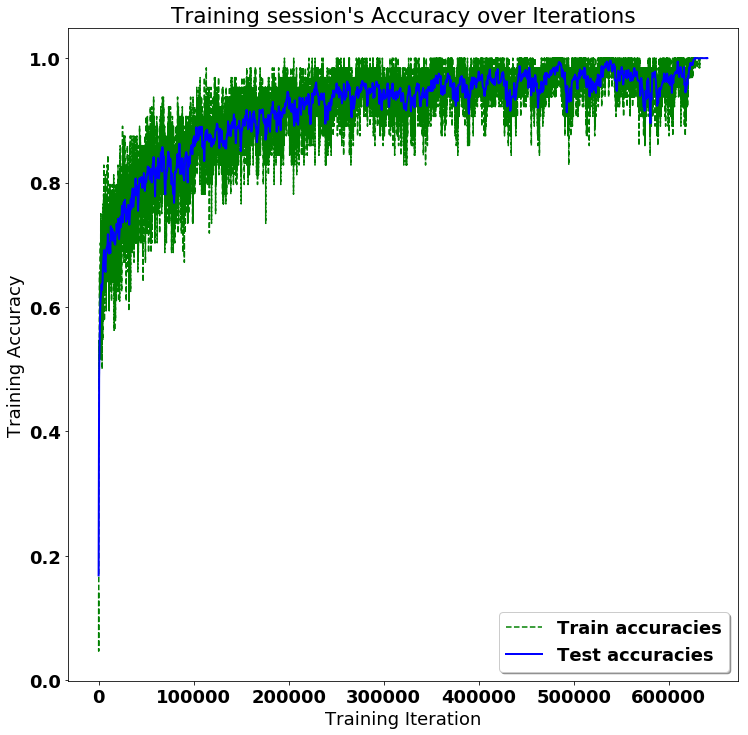

Testing Accuracy: 100.0%

Precision: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
Created using test set of 1251 datapoints, normalised to % of each class in the test dataset


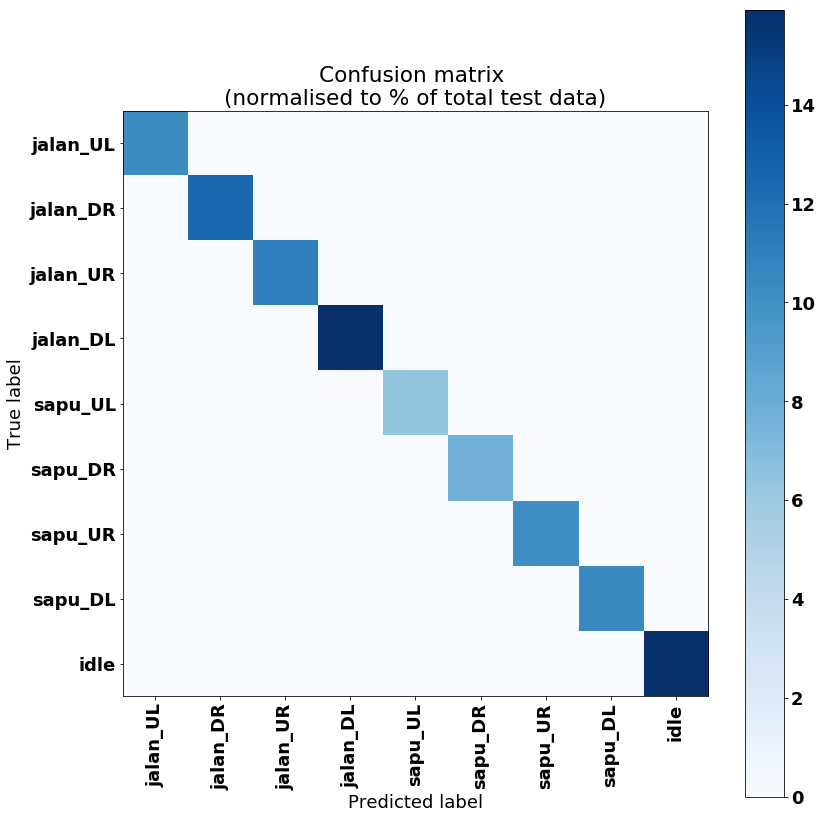

In [15]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy_fin))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [16]:


#
#X_val_path = DATASET_PATH + "X_val.txt"
#X_val = load_X(X_val_path)
#print X_val
#
#preds = sess.run(
#    [pred],
#    feed_dict={
#        x: X_val
#   }
#)
#
#print preds

In [17]:
#sess.close()
print(test_accuracies)

[0.16866507, 0.48840928, 0.5339728, 0.5883293, 0.6131095, 0.6227018, 0.63629097, 0.62749803, 0.6394884, 0.66746604, 0.6794564, 0.69144684, 0.6738609, 0.665068, 0.656275, 0.6802558, 0.6938449, 0.69704235, 0.696243, 0.71702635, 0.6898481, 0.68585134, 0.69704235, 0.7026379, 0.6866507, 0.72981614, 0.716227, 0.7178257, 0.72581935, 0.7066347, 0.7210232, 0.72022384, 0.70743406, 0.70183855, 0.70023984, 0.7146283, 0.71702635, 0.7338129, 0.72182256, 0.7210232, 0.74180657, 0.71302956, 0.7090328, 0.7226219, 0.7338129, 0.745004, 0.7282174, 0.74420464, 0.76258993, 0.74580336, 0.736211, 0.7665867, 0.7689848, 0.7521982, 0.7721822, 0.75859314, 0.7370104, 0.75619507, 0.7569944, 0.7529976, 0.7410072, 0.76418865, 0.7410072, 0.7322142, 0.7466027, 0.7633893, 0.77298164, 0.7569944, 0.77857715, 0.7809752, 0.7905675, 0.7609912, 0.7689848, 0.77458036, 0.7889688, 0.78017586, 0.80655473, 0.7793765, 0.7961631, 0.79456437, 0.7833733, 0.75459635, 0.77298164, 0.79696244, 0.80655473, 0.8009592, 0.8073541, 0.8009592, 0

## Conclusion

Final accuracy of >90% is pretty good, considering that training takes about 7 minutes.

Noticeable confusion between activities of Clapping Hands and Boxing, and between Jumping Jacks and Waving Two Hands which is understandable.

In terms of the applicability of this to a wider dataset, I would imagine that it would be able to work for any activities in which the training included a views from all angles to be tested on. It would be interesting to see it's applicability to camera angles in between the 4 used in this dataset, without training on them specifically.

 Overall, this experiment validates the idea that 2D pose can be used for at least human activity recognition, and provides verification to continue onto use of 2D pose for behaviour estimation in both people and animals
 

 ### With regards to Using LSTM-RNNs
 - Batch sampling
     - It is neccessary to ensure you are not just sampling classes one at a time! (ie y_train is ordered by class and batch chosen in order)The use of random sampling of batches without replacement from the training data resolves this.    
 
 - Architecture
     - Testing has been run using a variety of hidden units per LSTM cell, with results showing that testing accuracy achieves a higher score when using a number of hidden cells approximately equal to that of the input, ie 34. The following figure displays the final accuracy achieved on the testing dataset for a variety of hidden units, all using a batch size of 4096 and 300 epochs (a total of 1657 iterations, with testing performed every 8th iteration).
   
 
 

## Future Works

Inclusion of :

 - A pipeline for qualitative results
 - A validation dataset
 - Momentum     
 - Normalise input data (each point with respect to distribution of itself only)
 - Dropout
 - Comparison of effect of changing batch size
 

Further research will be made into the use on more subtle activity classes, such as walking versus running, agitated movement versus calm movement, and perhaps normal versus abnormal behaviour, based on a baseline of normal motion.


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [18]:
# Let's convert this notebook to a README for the GitHub project's title page:
# !jupyter nbconvert --to markdown LSTM.ipynb
# !mv LSTM.md README.md

## 

In [19]:
#### Camera

# import argparse
# import logging
# import time

# import cv2
# import numpy as np

# from tf_pose.estimator import TfPoseEstimator
# from tf_pose.networks import get_graph_path, model_wh

# logger = logging.getLogger('TfPoseEstimator-WebCam')
# logger.setLevel(logging.DEBUG)
# ch = logging.StreamHandler()
# ch.setLevel(logging.DEBUG)
# formatter = logging.Formatter('[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s')
# ch.setFormatter(formatter)
# logger.addHandler(ch)

# class openpose:
#     def __init__(self, camera=0,resize='0x0',resize_out_ratio=4.0,model='mobilenet_thin',show_process=False):

#         logger.debug('initialization %s : %s' % (model, get_graph_path(model)))
#         w, h = model_wh(resize)
#         if w > 0 and h > 0:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))
#         else:
#             e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
#         logger.debug('cam read+')
#         cam = cv2.VideoCapture(camera)
#         ret_val, image = cam.read()
#         logger.info('cam image=%dx%d' % (image.shape[1], image.shape[0]))
        
#         fps_time = 0

#         while True:
#             ret_val, image = cam.read()

#             logger.debug('image process+')
#             humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=resize_out_ratio)

#             logger.debug('postprocess+')
#             image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

#             logger.debug('show+')
#             cv2.putText(image,
#                         "FPS: %f" % (1.0 / (time.time() - fps_time)),
#                         (10, 10),  cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#                         (0, 255, 0), 2)
#             cv2.imshow('tf-pose-estimation result', image)
#             fps_time = time.time()
#             if cv2.waitKey(1) == 27:
#                 break
#             logger.debug('finished+')

#         cv2.destroyAllWindows()

# if __name__ == '__main__':
#     openpose()
